In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import inspect
import os
from ipywidgets import interact, IntSlider, Dropdown, VBox, Output
from matplotlib.animation import FuncAnimation, HTMLWriter, FFMpegWriter
import itertools
import datetime

In [2]:
d = 2

x = np.array([[-1/2,1],[2,1]])
y = np.array([2,-2])

n = len(y)

# Check if any element in the array is 0
if np.any(x == 0):
    print('Array x contains at least one element that is 0')
else:
    print('Array x does not contain any elements that are 0')

Array x does not contain any elements that are 0


In [3]:
def relu(x):
    return np.maximum(0, x)

def indicator(condition):
    return condition.astype(int)

In [4]:
# 2-Lyaer ReLu Neural Network
def twoLayerReluNet(a, w, x):
    return np.sum(a[:, np.newaxis] * relu(np.inner(w,x)), axis=0)

def loss(a, w, x, y):
    return (1/(2*n)) * np.sum((y - twoLayerReluNet(a, w, x))**2)

In [5]:
## Typical parameter gradients
def gradient_flow(a,w):
    
    relu_mask = (np.inner(w,x) > 0).astype(float)
    Dt = - 1/n * np.sum(((twoLayerReluNet(a, w, x) - y) * relu_mask)[:, :, np.newaxis] * x, axis=1) # Not sure about this one here

    grad_a = np.einsum('ij,ij->i', Dt, w) 
    grad_w = Dt * a[:, np.newaxis]
 
    return grad_a, grad_w

def generate_initial_data(lambda_param,m):
    mean = np.zeros(d)  # Mean vector with all zeros
    cov = np.eye(d)     # Covariance matrix as the identity matrix
    g = np.random.multivariate_normal(mean, cov, size=m)  # Generate n samples from the normal distribution
    w = lambda_param * g

    w_norms = np.linalg.norm(w, axis=1)
    s = np.random.choice([-1, 1], size=m)    
    a = w_norms * s

    return a, w, s

def generate_set_Splus_Sminus(s,w,m):
    # Compute dot products ⟨w_j^0, x_k⟩ for all j and k
    dot_products = np.inner(w,x)  # Shape (m, n)
    
    # Conditions
    pos_k_mask = y > 0  # Indices where y_k > 0
    neg_k_mask = y < 0  # Indices where y_k < 0

    Splus = np.array([i for i in range(m) if s[i] == 1 and np.all(dot_products[i, pos_k_mask] >= 0)])
    Sminus = np.array([i for i in range(m) if s[i] == -1 and np.all(dot_products[i, neg_k_mask] >= 0)])

    return Splus, Sminus

In [6]:
def gradient_descent(learning_rate, steps, lambda_param,m):

    a, w, s = generate_initial_data(lambda_param,m)
    sPlus, sMinus = generate_set_Splus_Sminus(s,w,m)

    np.save('weights\\s_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, steps), s)
    np.save('weights\\sPlus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, steps), sPlus)
    np.save('weights\\sMinus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, steps), sMinus)

    a_values = []
    w_values = []

    #for n in range(math.ceil(time/step_size)):
    for n in range(steps): 
        grad_a, grad_w = gradient_flow(a,w)
        a = a + learning_rate * grad_a
        w = w + learning_rate * grad_w

        # Save the current values of a, w, and b
        a_values.append(a.copy())
        w_values.append(w.copy())

    return a_values, w_values

In [7]:
def mathcalD(w, theta_a, theta_w):
    relu_mask = (np.inner(w,x) > 0).astype(float)
    Dt = - 1/n * np.sum(((twoLayerReluNet(theta_a, theta_w, x) - y) * relu_mask)[:, :, np.newaxis] * x, axis=1) # Not sure about this one here
    return Dt

def neuron_activation(w):
    return np.sign(np.inner(w,x))

def inverse_neuron_activation(u):
    # look into sympy
    return 0
    
def mathcalD_u(u):
    relu_mask = (u > 0).astype(float)
    Dt = 1/n * np.sum((y * relu_mask)[:,:, np.newaxis] * x, axis=1) # Not sure about this one here
    return Dt

def funcG(w):
    zero_w = np.zeros([1,d])
    zero_a = np.zeros([1])
    
    return np.inner(w,mathcalD(w, zero_a, zero_w))

def funcG_non_zero(w, theta_a, theta_w):
    return np.inner(w,mathcalD(w, theta_a, theta_w))

def activation_cone(u, coord=None):
    d_size = np.linspace(-1, 1, 400)
    x_free, y_free = np.meshgrid(d_size, d_size)

    feasible = np.ones(x_free.shape, dtype=bool)

    for i in range(len(x)):
        feasible = feasible & (u[i] * (x_free * x[i, 0] + y_free * x[i, 1]) >= 0)


    if coord is not None:
        x_coord, y_coord = coord
        is_feasible = all(u[i] * (x_coord * x[i, 0] + y_coord * x[i, 1]) >= 0 for i in range(len(x)))
        return feasible.astype(int), is_feasible

    return feasible.astype(int)

def is_extremal_vector(u, coord):
    x_coord, y_coord = coord
    return all(u[i] * (x_coord * x[i, 0] + y_coord * x[i, 1]) >= 0 for i in range(len(x)))

C:\Users\malco\AppData\Local\Temp\ipykernel_5952\851893025.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i] = funcG(np.array([[x_plot[i], y_plot[i]]]))


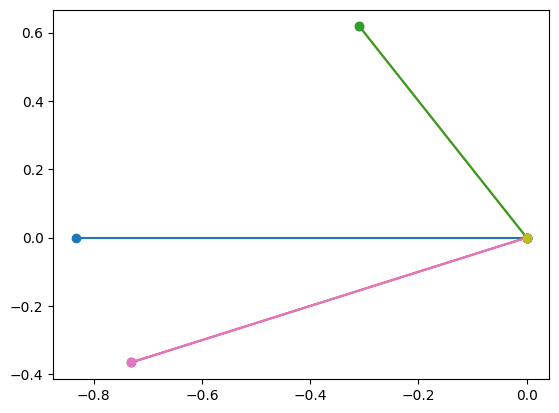

interactive(children=(Dropdown(description='Permutation', options=(((1, 1), (1, 1)), ((1, 0), (1, 0)), ((1, -1…

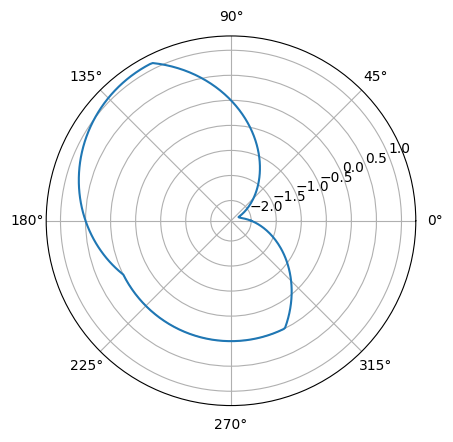

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact, Dropdown

# Generate points on a 2D circle
theta = np.linspace(0, 2 * np.pi, 400)
x_plot = np.cos(theta)
y_plot = np.sin(theta)

# Apply the function to each point
z = np.zeros(len(x_plot))
for i in range(len(x_plot)):
    z[i] = funcG(np.array([[x_plot[i], y_plot[i]]]))

# Create a dropdown menu for selecting the permutation
permutations = list(itertools.product([1, 0, -1], repeat=n))
# Dropdown considers (a,b) a tuple of label a and value b when n = 2
if n == 2:
    permutation_dropdown = Dropdown(options=[(p,p) for p in permutations], description='Permutation')
else:
    permutation_dropdown = Dropdown(options=permutations, description='Permutation')

# Perform elementwise multiplication using broadcasting
y_x = y[:, np.newaxis] * x

for permutation in permutations:
    # Select and sum the elements of y_x based on the permutation
    selected_elements = y_x[np.array(permutation) == 1]
    sum_vector = np.sum(selected_elements, axis=0)

    # Normalize the result
    normalized_vector = sum_vector / (1+np.linalg.norm(sum_vector))

    # Plot the normalized result
    plt.plot([0, normalized_vector[0]], [0, normalized_vector[1]], marker='o')

def recursive_interval_additions(selected_elements, u, y_x, k):
        if(k == n):
            sum_vector = np.sum(selected_elements, axis=0)
            normalized_vector = sum_vector / (1+np.linalg.norm(sum_vector))
            plt.plot([0, normalized_vector[0]], [0, normalized_vector[1]], marker='o', color = 'red')
            return
        if(u[k] == 0):
            recursive_interval_additions(np.append(selected_elements, [y_x[k]], axis=0) , u, y_x, k+1)
        recursive_interval_additions(selected_elements, u, y_x, k+1)

def plot_permutation(permutation):
    plt.figure(figsize=(8, 8))
    plt.scatter(x_plot, y_plot, c='black')
    for x_val in x:
        plot_line(x_val)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Function Values on a 2D Sphere')
    plt.axis('equal')

    u = np.array(permutation)
    # Select and sum the elements of y_x based on the permutation
    selected_elements = y_x[u == 1]
    sum_vector = np.sum(selected_elements, axis=0)
    # Normalize the result
    normalized_vector = sum_vector / (1+np.linalg.norm(sum_vector))
    # Plot the normalized result
    
    if np.any(u == 0):
        recursive_interval_additions(selected_elements, u, y_x, 0)

    plt.plot([0, normalized_vector[0]], [0, normalized_vector[1]], marker='o', color='blue')

    u = np.array([permutation])

    vec = mathcalD_u(u)
    r = np.linalg.norm(vec)
    vec_on_circle = vec / r

    inverse_A, extremal_vector = activation_cone(u[0], vec_on_circle[0]) 

    if np.any(u == 0):
        indexes = np.where(u == 0)[1]
        for i in indexes:
            plot_line(x[i], 5)
    else:
        plt.imshow(inverse_A, extent=(-1, 1, -1, 1), origin="lower", cmap="Greys", alpha=0.3)
        plt.imshow(np.rot90(inverse_A, 2), extent=(-1, 1, -1, 1), origin="lower", cmap="Greys", alpha=0.3)

    vec = mathcalD_u(u)
    r = np.linalg.norm(vec)
    vec_on_circle = vec / r

    plt.ylim(-1, 1)
    plt.xlim(-1, 1)

# Define the function to plot the line
def plot_line(w,linewidth=1):
    # Extract weights
    w1, w2 = w

    # Generate x1 values
    x1 = np.linspace(-1, 1, 40)

    # Calculate corresponding x2 values
    x2 = - (w1 * x1) / w2

    # Plot the line
    plt.plot(x1, x2, linewidth=linewidth)

def plot_permutation_radius(permutation):
    plt.polar(theta, z)

output = interact(plot_permutation, permutation=permutation_dropdown)
# interact(plot_permutation_radius, permutation=permutation_dropdown)
plt.polar(theta, z)

In [9]:
def train(n_steps, learning_rate, lambda_param,m):
    a_values, w_values = gradient_descent(learning_rate, n_steps, lambda_param,m)

    # Convert lists to arrays for easier saving and plotting
    a_values = np.array(a_values)
    w_values = np.array(w_values)

    # Save the arrays to disk
    np.save('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps), a_values)
    np.save('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps), w_values)

    print(f'Completed training for steps: {n_steps}, learning rate: {learning_rate}, m value: {m}')

m = 60
lambda_param = 1e-6/ math.sqrt(m)
learning_rate = 1e-3
n_steps = 15000

# lambda_param = 1e-10/ math.sqrt(m)
# learning_rate = 1e-3
# n_steps = 250000


train(n_steps, learning_rate, lambda_param,m)

Completed training for steps: 15000, learning rate: 0.001, m value: 60


In [ ]:
current_a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
current_w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
current_s_values = np.load('weights\\s_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))

sPlus = np.load('weights\\sPlus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
sMinus = np.load('weights\\sMinus_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
remaining = np.setdiff1d(np.arange(m), np.concatenate((sPlus, sMinus)))

# Generate the first coordinate ranging from -3 to 2
first_coord = np.linspace(-4, 4, 100)  # This will create an array from -3 to 2 (inclusive)

# Generate the second coordinate as an array of ones with the same length as first_coord
second_coord = np.ones_like(first_coord)

# Combine the two coordinates into a single array
x_graph = np.column_stack((first_coord, second_coord))
indices = np.arange(n_steps)

output = Output()

def get_loss(a_vals, w_vals, index):
    a = a_vals[index]
    w = w_vals[index]
    return loss(a, w, x, y)

def rescale_magnitudes(w):
    scale = 1.5

    w_norms = np.linalg.norm(w, axis=1)
    # w_norms = np.log( np.linalg.norm(w, axis=1))


    w_norms_rescaled = 0.2 + scale*(w_norms)/(1 + w_norms)
    #w_norms_rescaled = w_norms 
    return w_norms_rescaled

def get_weight_plots(w):
    weights_x = - w[:,1] / w[:,0]
    w_norms = np.linalg.norm(w, axis=1)
    weights_y = current_s_values * w_norms
    return weights_x, weights_y

loss_values = np.zeros(n_steps)
for i in range(n_steps):
    loss_values[i] = get_loss(current_a_values, current_w_values, i)

extremal_vectors = np.empty((0, 2))

# Generate points on a 2D circle
theta = np.linspace(0, 2 * np.pi, 100)
x_plot = np.cos(theta)
y_plot = np.sin(theta)

# Apply the function to each point
z = np.zeros(len(x_plot))
for i in range(len(x_plot)):
    z[i] = funcG(np.array([[x_plot[i], y_plot[i]]])).item()

permutations = list(itertools.product([-1, 1], repeat=n))
for perm in permutations:
    u = np.array([perm])
    vec = mathcalD_u(u)
    vec_on_circle = vec / np.linalg.norm(vec)
    if is_extremal_vector(u[0], vec_on_circle[0]):
        extremal_vectors = np.vstack((extremal_vectors, vec))

def gen_plot(ax1, ax2, ax3, index, w, weight_plot_x, weight_plot_y, y_graph):

    z = np.array([funcG_non_zero(np.array([[x_plot[i], y_plot[i]]]), current_a_values[index], current_w_values[index]).item() for i in range(len(x_plot))])

    # # Rescale z values to be between 0 and 1
    # z_min , z_max = np.min(z), np.max(z)
    # z = (z - z_min) / (z_max - z_min)

    r_lim = 0.8

    ax1.plot(np.arctan2(w[:,1], w[:,0])[sPlus], rescale_magnitudes(w)[sPlus], 'o', color='green', alpha=0.5)
    ax1.plot(np.arctan2(w[:,1], w[:,0])[sMinus], rescale_magnitudes(w)[sMinus], 'o', color='red', alpha=0.5)
    ax1.plot(np.arctan2(w[:,1], w[:,0])[remaining], rescale_magnitudes(w)[remaining], 'o', color='blue', alpha=0.5)
    ax1.plot(np.arctan2(x[:,1], x[:,0]), np.full(len(x),r_lim), 'x', color='black', alpha=0.5)
    ax1.plot(theta, z, zorder=100)
    ax1.grid(True)
    #ax1.set_rscale('log', base=np.e)
    #ax1.set_rlim(0,r_lim*1.5)
    #ax1.set_yticklabels([])

    for vec in extremal_vectors:
        angle = np.arctan2(vec[1], vec[0])
        ax1.plot([0,angle], [0, r_lim], marker='o', linestyle='--', linewidth=0.5)


    inner_circle = plt.Circle((0, 0), 0.2, transform=ax1.transProjectionAffine + ax1.transAxes, facecolor='white', edgecolor='black', zorder=10)
    ax1.add_patch(inner_circle)  # Overlay the circle


    ax2.scatter(x[:,0], y, c='green', alpha=0.5, label='Data points')
    ax2.plot(x_graph[:,0], y_graph, color='green', label=f'm={m}, index={index}', linewidth=1.5)
    ax2.scatter(weight_plot_x[sPlus], weight_plot_y[sPlus], c='green', marker=(5, 1))
    ax2.scatter(weight_plot_x[sMinus], weight_plot_y[sMinus], c='red', marker=(5, 1))
    ax2.scatter(weight_plot_x[remaining], weight_plot_y[remaining], c='blue', marker=(5, 1))
    ax2.grid(True)
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(-3, 3)
    

    # Plot the precomputed loss values
    ax3.plot(indices, loss_values)
    ax3.axvline(x=index, color='blue', linestyle='--', linewidth=0.5)
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Loss')
    ax3.grid(True)
    ax3.tick_params(bottom=True, left=False)
    
def plot_values(index):

    fig = plt.figure(figsize=(12, 8))
    ax1 = plt.subplot(2, 2, 1, polar=True)
    ax2 = plt.subplot(2, 2, 2)
    ax3 = plt.subplot(2, 1, 2)

    a = current_a_values[index]
    w = current_w_values[index]

    # Compute the corresponding y values
    y_graph = twoLayerReluNet(a, w, x_graph)

    weight_plot_x ,weight_plot_y = get_weight_plots(w)

    with output:
        output.clear_output(wait=True)
        gen_plot(ax1, ax2, ax3, index, w, weight_plot_x, weight_plot_y, y_graph)
        plt.show()



# Create a slider for selecting the index
slider = IntSlider(min=0, max=len(current_a_values)-1, step=1, value=0, description='Index')

# Use interact to create an interactive plot
interact(plot_values, index=slider)

# Display the output widget
display(output)

C:\Users\malco\AppData\Local\Temp\ipykernel_5952\2688379815.py:63: RuntimeWarning: invalid value encountered in divide
  vec_on_circle = vec / np.linalg.norm(vec)


interactive(children=(IntSlider(value=0, description='Index', max=14999), Output()), _dom_classes=('widget-int…

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


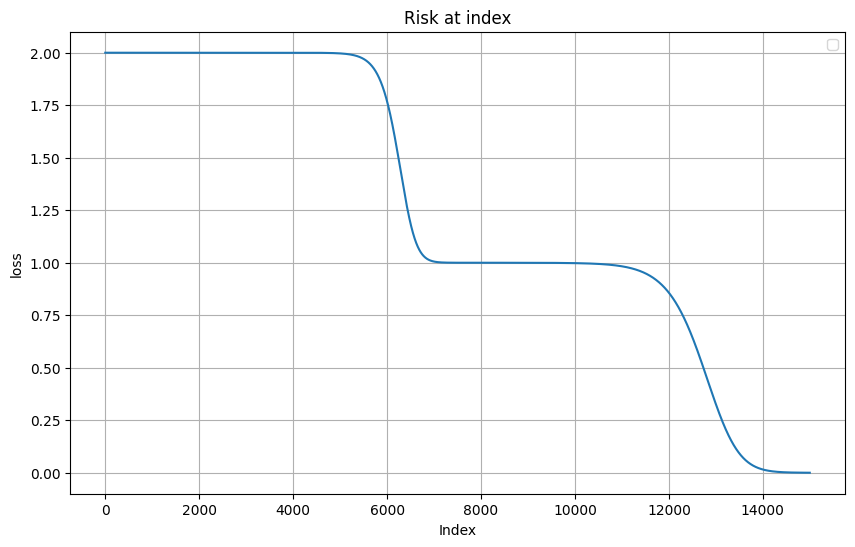

In [15]:
# Define the function to plot the values at a given index
def get_loss(a_vals, w_vals, index):
    a = a_vals[index]
    w = w_vals[index]
    
    return loss(a, w, x, y)

def generate_loss_plot(n_steps, learning_rate):

    # Create an array of indices
    indices = np.arange(n_steps)

    plt.figure(figsize=(10, 6))

    # Load the arrays from disk
    a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))

    loss = np.zeros((int)(n_steps))
    # Load min and max values obtained by graph at index
    for n in range((int)(n_steps)):
        loss[n] = get_loss(a_values, w_values, n)

    # Plot the min and max values
    plt.plot(indices, loss)

        
    #filename = f'LossPlot_M{m}_Learning{learning_rate}_Steps{n_steps}.svg'

    plt.xlabel(f'Index')
    plt.ylabel('loss')
    plt.title('Risk at index') # TODO: Recheck the text for labels and title
    plt.legend()
    plt.grid(True)
    plt.show()

generate_loss_plot(n_steps, learning_rate)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


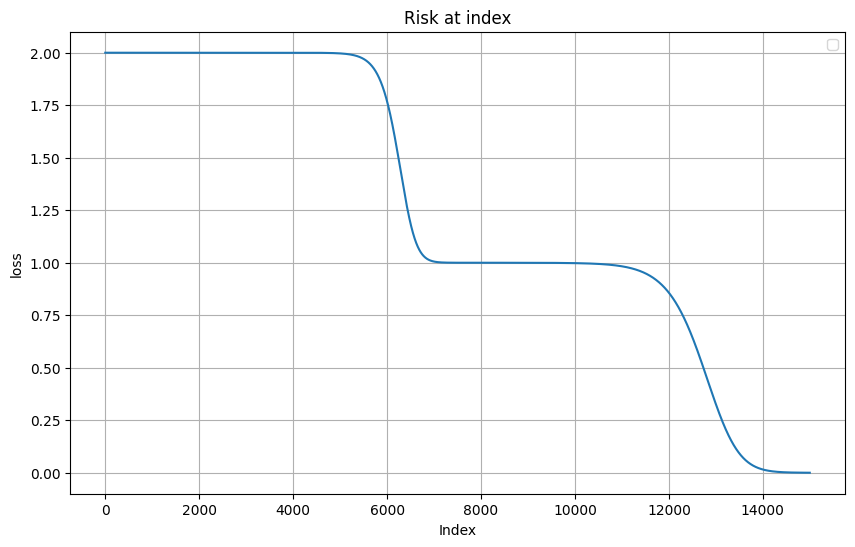

In [12]:
# Define the function to plot the values at a given index
def get_loss(a_vals, w_vals, index):
    a = a_vals[index]
    w = w_vals[index]
    
    return loss(a, w, x, y)

def generate_loss_plot(n_steps, learning_rate):

    # Create an array of indices
    indices = np.arange(n_steps)

    plt.figure(figsize=(10, 6))

    # Load the arrays from disk
    a_values = np.load('weights\\a_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))
    w_values = np.load('weights\\w_values_m%d_Learning%d_Steps%d.npy' % (m, learning_rate, n_steps))

    loss = np.zeros((int)(n_steps))
    # Load min and max values obtained by graph at index
    for n in range((int)(n_steps)):
        loss[n] = get_loss(a_values, w_values, n)

    # Plot the min and max values
    plt.plot(indices, loss)

        
    #filename = f'LossPlot_M{m}_Learning{learning_rate}_Steps{n_steps}.svg'

    plt.xlabel(f'Index')
    plt.ylabel('loss')
    plt.title('Risk at index') # TODO: Recheck the text for labels and title
    plt.legend()
    plt.grid(True)
    plt.show()

generate_loss_plot(n_steps, learning_rate)

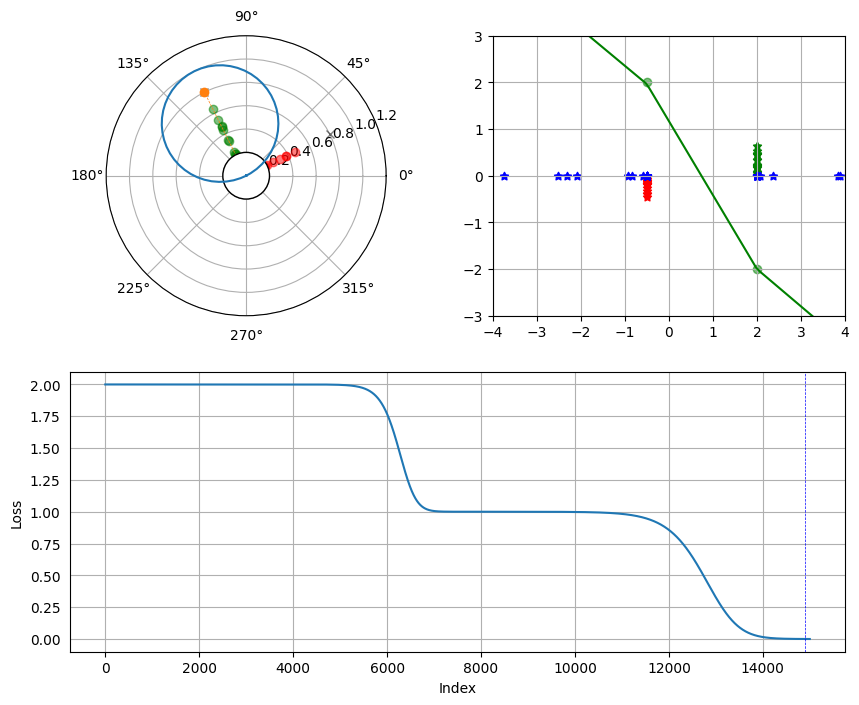

In [17]:
def update(index):
    a = current_a_values[index]
    w = current_w_values[index]

    # Compute the corresponding y values
    y_graph = twoLayerReluNet(a, w, x_graph)
    weight_plot_x ,weight_plot_y = get_weight_plots(w)

    # Clear the previous plot and create a new one
    ax1.clear()
    ax2.clear()
    ax3.clear()

    gen_plot(ax1, ax2, ax3, index, w, weight_plot_x, weight_plot_y, y_graph)

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2, 2, 1, polar=True)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 1, 2)

# Set the total duration of the animation (in seconds)
total_duration = 30  # 10 seconds

# Skip to every 100th frame
frame_skip = 100
frames = range(0, n_steps, frame_skip)

# Calculate the interval between frames (in milliseconds)
interval = (total_duration * 1000) / len(frames)

# Create the animation
ani = FuncAnimation(fig, update, frames=frames, interval=interval, repeat=False)

# Create the writer
ffmpeg_writer = FFMpegWriter(fps=10)

# Generate a unique timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the animation
ani.save(f'animations\\animation_{timestamp}.mp4', writer=ffmpeg_writer)

# Display the animation
plt.show()